In [5]:
# подготовка данных и обучение модели
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# пример данных
data = pd.DataFrame({
    'user_id': [1, 2, 3, 4, 5, 6,7,8,9,10],
    'treatment': [1, 0, 1, 0, 1, 0,1,1,1,0],
    'num_trips': [10, 8, 12, 7, 9, 6,2,5,3,1],
    'avg_trip_cost': [15, 12, 14, 11, 13, 10,12,15,14,10],
    'gender': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'location': ['City A', 'City B', 'City A', 'City B', 'City A', 'City B', 'City B', 'City A', 'City B', 'City B'],
    'target': [5, 2, 7, 1, 4, 0,2,5,6,7]
})

# трансформация целевой переменной
data['target_transformed'] = data.apply(
    lambda row: row['target'] if row['treatment'] == 1 else -row['target'], axis=1)

# целевая переменная и признаки
y = data['target_transformed']
X = data.drop(['target', 'target_transformed', 'user_id'], axis=1)

# разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# предобработка данных
numeric_features = ['num_trips', 'avg_trip_cost']
categorical_features = ['gender', 'location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# модель
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# обучение модели
model.fit(X_train, y_train)

# оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Predictions:", y_pred)

Mean Squared Error: 6.3007
Predictions: [ 2.86  0.05 -2.2 ]


In [6]:
# применение модели ко всем данным для принятия решения о предоставлении скидок
all_data_predictions = model.predict(X)

# устанавливаем порогового значения для предоставления скидок
threshold = 1.0  # пороговое значение можно настроить 

In [7]:
# определение пользователей, которым рекомендуется предоставить скидку
data['predicted_uplift'] = all_data_predictions
data['give_discount'] = data['predicted_uplift'] > threshold
# вывод пользователей, которым рекомендуется предоставить скидку
users_to_give_discount = data[data['give_discount']]

print("Users to give discount:")
print(users_to_give_discount[['user_id', 'predicted_uplift']]) 

Users to give discount:
   user_id  predicted_uplift
0        1              5.07
2        3              6.23
4        5              4.49
7        8              3.57
8        9              2.86


In [10]:
import pandas as pd
import numpy as np

# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,
    'outcome': outcome,
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.tail(20)) 

    user_id  treatment  outcome  uplift_prediction
80       81          0        0           0.341066
81       82          0        0           0.113474
82       83          0        0           0.924694
83       84          0        1           0.877339
84       85          0        0           0.257942
85       86          0        0           0.659984
86       87          0        0           0.817222
87       88          0        0           0.555201
88       89          0        0           0.529651
89       90          0        0           0.241852
90       91          0        0           0.093103
91       92          0        0           0.897216
92       93          0        0           0.900418
93       94          0        0           0.633101
94       95          0        0           0.339030
95       96          0        0           0.349210
96       97          0        0           0.725956
97       98          0        0           0.897110
98       99          0        1

In [11]:
df = df.sort_values(by='uplift_prediction', ascending=False).reset_index(drop=True)
print(df.head()) 

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


In [12]:
# инициализация переменных
nt = 0
nt_1 = 0
nc = 0
nc_1 = 0
cgain = []
random = []
optimum = []
incremental_purchases = 0
opt_incremental_purchases = df['outcome'].sum() 

In [13]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0)) 

In [14]:
from sklearn.metrics import auc

# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}') 

Qini Score: -264.3900000000001


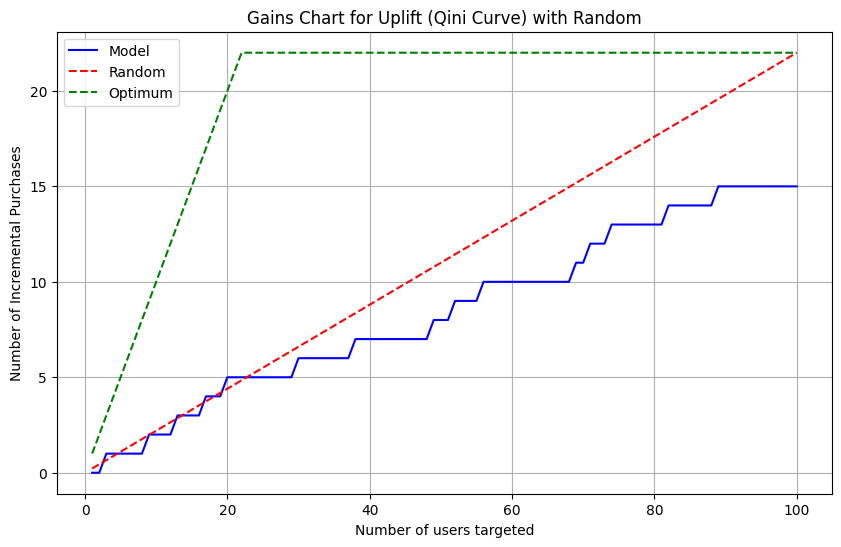

In [15]:
import matplotlib.pyplot as plt

# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show() 

In [6]:
data_set = pd.read_csv('discountuplift.csv',delimiter='\t')
data_set.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


In [7]:
discount = data_set[['uplift_score','target_class']]

In [10]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

%matplotlib inline

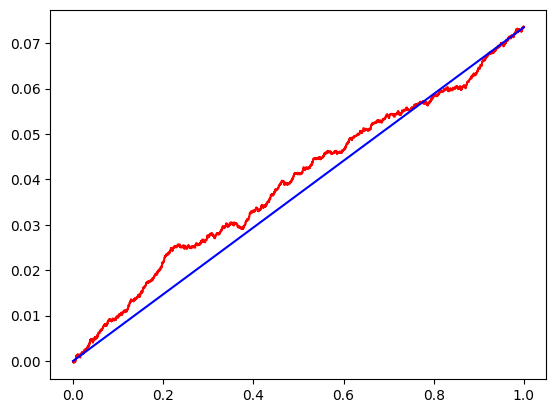

33.178779999999996

In [12]:

# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values(by='uplift_score',ascending=False).copy()
    
    N_c = sum(ranked['target_class'] <= 1) # контрольная выборка
    N_t = sum(ranked['target_class'] >= 2) # выборка с воздействием (скидка предоставлена)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1  # контрольная выборка + купили товар
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1  # выборка с воздействием (скидка), купили товар
    
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    #final_dot = ranked['n_t1'].sum()/N_t - ranked['n_c1'].sum()/N_c
    final_dot = ranked['uplift'].iloc[-1]
    #ranked['random_uplift'] = np.linspace(0,final_dot,len(ranked))
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount) 

In [1]:
import pandas as pd
import numpy as np
FILENAME = 'discountuplift.csv'
# загрузим данные пользователей
data = pd.read_csv(FILENAME,delimiter='\t')

# добавим колонку с группой (контрольная или экспериментальная)
np.random.seed(42)  # для воспроизводимости результатов
data['group'] = np.random.choice(['control', 'experiment'], size=len(data))

# сохраним контрольную и экспериментальную группы в отдельные переменные
control_group = data[data['group'] == 'control']
experiment_group = data[data['group'] == 'experiment']

In [3]:
data = pd.read_csv(FILENAME,delimiter='\t')
data['group'] = np.where(data['target_class'] <= 1,'control','experiment')

In [4]:
data['discount'] = np.where(data['group'] == 'experiment', True, False)
data.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,group,discount
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0,control,False
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0,control,False
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2,experiment,True
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2,experiment,True
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2,experiment,True


In [ ]:
# создадим DataFrame для хранения результатов теста
results = pd.DataFrame(columns=['user_id', 'group', 'num_rides', 'total_spent'])

# симуляция данных для каждой группы
# для простоты примера мы используем случайные данные
for _, row in data.iterrows():
    num_rides = np.random.poisson(lam=5 if row['discount'] else 3)  # предполагаем, что скидки увеличивают среднее количество поездок
    total_spent = num_rides * (20 if row['discount'] else 25)  # допустим, что средняя стоимость поездки отличается
    
    results = results.append({
        'user_id': row['user_id'],
        'group': row['group'],
        'num_rides': num_rides,
        'total_spent': total_spent
    }, ignore_index=True)

# сохраним результаты
results.to_csv('ab_test_results.csv', index=False) 

In [5]:
from scipy import stats
  
# загрузим результаты теста
results = data
  
# группируем данные
grouped_results = results.groupby('group').agg({
  'recency': ['mean', 'std', 'count'],
  'history': ['mean', 'std', 'count']
  })
  
print(grouped_results)
  
# сравниваем средние значения количества поездок
control_rides = results[results['group'] == 'control']['recency']
experiment_rides = results[results['group'] == 'experiment']['recency']
  
t_stat, p_value = stats.ttest_ind(control_rides, experiment_rides)
print(f"t-statistic: {t_stat}, p-value: {p_value}")
  
# оцениваем, насколько значимо увеличилось количество поездок в экспериментальной группе
if p_value < 0.05:
  print("Различие в количестве поездок между контрольной и экспериментальной группами статистически значимо.")
else:
  print("Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.")
  

             recency                     history                  
                mean       std count        mean         std count
group                                                             
control     5.708698  3.476402  6392  240.717911  254.045802  6392
experiment  5.720901  3.521401  6392  246.022326  268.524044  6392
t-statistic: -0.1971607887028107, p-value: 0.8437048492371803
Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.


In [13]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания 
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [16]:
df['old_target'] = np.where(df['target_class'].isin([1,3]), 1,0)
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = ['old_target']
treatment_col = 'treatment'

In [17]:
len(df[df['old_target'] == 1])

1878

In [20]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size=0.25,random_state=1)

In [21]:
round(len(df_train[df_train['old_target']==1])/len(df_train),5)

0.14727

In [22]:
from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])

s_learner.intercept_

array([-1.38679632])

In [25]:
round(s_learner.intercept_[0],5)

-1.3868

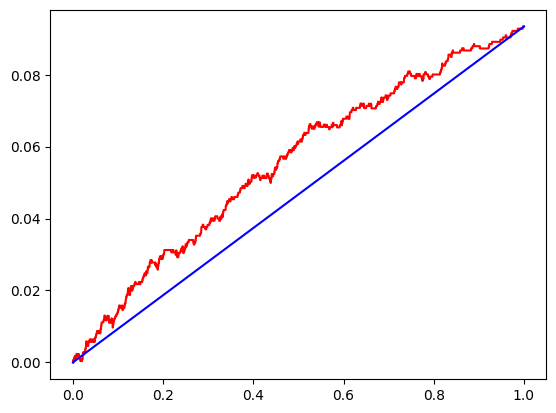

27.25506

In [26]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

qini_df(df_test)

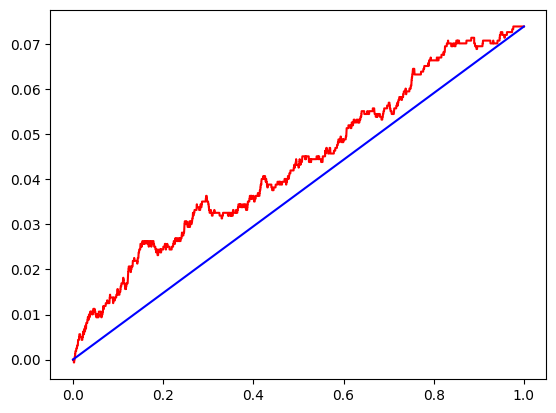

20.993380000000002

In [27]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(verbose=0, random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])
              
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

qini_df(df_test)

In [33]:
t_learner_1 = LogisticRegression(verbose=0, random_state=1)
t_learner_0 = LogisticRegression(verbose=0, random_state=1)

# обучите модели
t_learner_1.fit(X=df_train[df_train[treatment_col] == 1][feature_cols],
              y=df_train[df_train[treatment_col] == 1][target_col])
t_learner_0.fit(X=df_train[df_train[treatment_col] == 0][feature_cols],
              y=df_train[df_train[treatment_col] == 0][target_col])
# t_learner_1 — модель, обученная на выборке с воздействием
# t_learner_0 — модель, обученная на выборке без воздействия

# посчитайте и выведите intercept t_learner_1
print(round(t_learner_1.intercept_[0],5))
# посчитайте и выведите intercept t_learner_0 
print(round(t_learner_0.intercept_[0],5))

-1.03023
-1.23096


In [35]:
df_test[df_test[treatment_col] == 1][feature_cols]

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
8348,9,718.64,1,0,1,1,0,0,1,0,0
6137,4,135.53,0,1,0,0,0,1,0,1,0
5198,4,98.09,0,1,0,0,1,0,0,1,0
11830,4,102.07,0,1,1,1,0,0,0,1,0
7148,4,929.49,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9516,1,116.18,1,0,1,0,0,1,0,0,1
5144,3,897.31,1,1,1,0,0,1,0,0,1
7242,4,596.79,1,1,1,0,0,1,0,0,1
10608,2,56.86,1,0,1,0,0,1,0,1,0


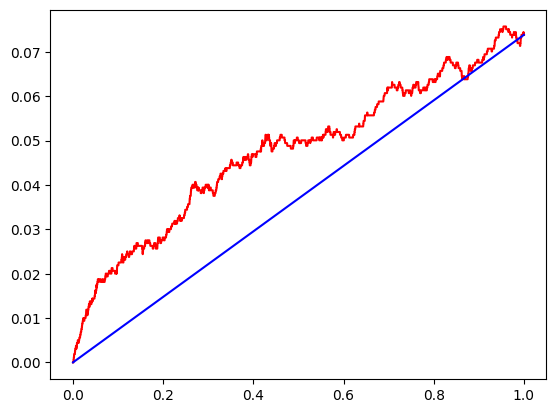

33.29271

In [36]:
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

df_test['yes_treatment'] = t_learner_1.predict_proba(df_test[feature_cols])[:,1]
df_test['no_treatment']  = t_learner_0.predict_proba(df_test[feature_cols])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals
qini_df(df_test) 